In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import xarray #as xr
from wofscast.data_generator import to_static_vars, add_local_solar_time

# For training the weights!
import optax

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wofscast.plot import WoFSColors, WoFSLevels
from datetime import datetime
import pandas as pd

def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]


In [3]:
def construct_wrapped_graphcast(model_config: graphcast.ModelConfig, 
                                task_config: graphcast.TaskConfig,
                                #norm_stats: dict
                               ):
    """Constructs and wraps the GraphCast Predictor."""
    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
     diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level
    )

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template=targets_template, forcings=forcings)


# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model.model_params, state=model.state)

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
    return functools.partial(
      fn, model_config=model.model_config, task_config=model.task_config)

class WoFSCastRunner:
    def __init__(self, model_path, 
                 total_forward_time_minutes = '60min', 
                 timestep_minutes = '10min',
                 norm_stats_path = '/work/mflora/wofs-cast-data/normalization_stats', 
                 domain_size = None
                ):
        
        model_data = self.load_model(model_path)
        self.timestep_minutes = timestep_minutes
        self.n_timesteps = int(total_forward_time_minutes.split('min')[0]) // int(timestep_minutes.split('min')[0])
        self.domain_size = domain_size
    
        self.train_lead_times = slice(timestep_minutes, total_forward_time_minutes)
    
        self.model_params = model_data['parameters']
        self.state = {}
        self._init_task_config(model_data['task_config'])
        self._init_model_config(model_data['model_config'])

        self._load_norm_stats(norm_stats_path)
        
    def predict(self, inputs, targets, forcings): 
       # Convert the constant fields to time-independent (drop time dim)
        inputs = to_static_vars(inputs)

        # It is crucial to tranpose the data so that level is last 
        # since the input includes 2D & 3D variables. 
        inputs = self._transpose(inputs, ['batch', 'time', 'lat', 'lon', 'level'])
        targets = self._transpose(targets, ['batch', 'time', 'lat', 'lon', 'level'])
        forcings = self._transpose(forcings, ['batch', 'time', 'lat', 'lon'])
        
        #targets_template = self.expand_time_dim(targets) * np.nan
        targets_template = targets * np.nan
        
        #print("Inputs:           ", inputs.dims.mapping)
        #print("Target Template:  ", targets_template.dims.mapping)
        #print("Forcings:         ", forcings.dims.mapping)
        
        run_forward_jitted = drop_state(with_params(jax.jit(with_configs(
            run_forward.apply))))

        # @title Autoregressive rollout (keep the loop in JAX)
        predictions = rollout.chunked_prediction(
            run_forward_jitted,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=targets_template,
            forcings=forcings)

        return predictions #, targets, inputs
    
    def _transpose(self, ds, dims):
        return ds.transpose(*dims, missing_dims='ignore')    
    
    def expand_time_dim(self, ds, forcings=False):
        # Repeat the time dimension n_timesteps number of times 
        # Use isel to select the slice and tile to repeat it
        repeated_slices = [ds.isel(time=0)] * self.n_timesteps
    
        # Concatenate the repeated slices along the 'time' dimension
        expanded_ds = xarray.concat(repeated_slices, dim='time')

        # Add a new datetime for the forcing variables. 
        # Generate the datetime range. 
        if forcings: 
            start_time = ds.datetime[0].values
            time_range = pd.date_range(start=start_time, periods=self.n_timesteps, freq=self.timestep_minutes)
            expanded_ds['time'] = time_range
            expanded_ds = expanded_ds.assign_coords(datetime=time_range)

            # Convert 'time' dimension to timedeltas from the first time point
            time_deltas = (expanded_ds['time'] - expanded_ds['time'][0]).astype('timedelta64[ns]')
            expanded_ds['time'] = time_deltas

        expanded_ds = self._transpose(expanded_ds, ['batch', 'time', 'lat', 'lon', 'level', 'datetime'])
    
        return expanded_ds

    
    # Load the model 
    def load_model(self, path):
        with open(path, 'rb') as f:
            data = checkpoint.load(f, dict)
    
        #Unravel the task config. 
        _TASK_CONFIG_KEYS = list(vars(graphcast.TaskConfig)['__dataclass_fields__'].keys())
    
        task_config = data['task_config']
    
        task_config_dict = {}
        for key in _TASK_CONFIG_KEYS: 
            if isinstance(task_config[key], dict):
                # unravel
                if key == 'pressure_levels':
                    task_config_dict[key] = [int(item) for _, item in task_config[key].items()]
                else:
                    task_config_dict[key] = [str(item) for _, item in task_config[key].items()]
            elif key == 'input_duration':
                task_config_dict[key] = str(task_config[key])
            else:
                task_config_dict[key] = task_config[key]
    
    
        data['task_config'] = task_config_dict
    
        return data 
    
    def _init_task_config(self, data): 

        domain_size =self.domain_size if self.domain_size else data['domain_size']
        
        self.task_config = graphcast.TaskConfig(
              input_variables=data['input_variables'],
              target_variables=data['target_variables'],
              forcing_variables=data['forcing_variables'],
              pressure_levels=data['pressure_levels'],
              input_duration=data['input_duration'],
              n_vars_2D = data['n_vars_2D'],
              domain_size = domain_size
          )
    
    def _init_model_config(self, data):
        self.model_config = graphcast.ModelConfig(
              resolution=int(data['resolution']),
              mesh_size=int(data['mesh_size']),
              latent_size=int(data['latent_size']),
              gnn_msg_steps=int(data['gnn_msg_steps']),
              hidden_layers=int(data['hidden_layers']),
              grid_to_mesh_node_dist=int(data['grid_to_mesh_node_dist']),
              loss_weights = data['loss_weights'],
        )
    
    def _load_norm_stats(self, path):     
        mean_by_level = xarray.load_dataset(os.path.join(path, 'mean_by_level.nc'))
        stddev_by_level = xarray.load_dataset(os.path.join(path, 'stddev_by_level.nc'))
        diffs_stddev_by_level = xarray.load_dataset(os.path.join(path, 'diffs_stddev_by_level.nc'))

        self.norm_stats = {'mean_by_level': mean_by_level, 
                      'stddev_by_level' : stddev_by_level,
                      'diffs_stddev_by_level' : diffs_stddev_by_level
                     }


In [4]:
from tqdm.notebook import tqdm
def read_netcdfs(paths, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xarray.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds
        
    datasets = [process_one_path(p) for p in tqdm(paths, desc="Processing files")]
    combined = xarray.concat(datasets, dim)
    return combined

In [21]:
base_path = '/work/mflora/wofs-cast-data/datasets_2hr/2021'
name = 'wrfwof_2021-05-13_230000_to_2021-05-14_011000__10min__ens_mem_05.nc'

path = os.path.join(base_path, name)

ens_paths = glob(f"{path.split('ens_mem')[0]}*")
ens_paths.sort()

dataset = read_netcdfs(ens_paths, dim='ensemble', transform_func=add_local_solar_time)


Processing files:   0%|          | 0/18 [00:00<?, ?it/s]

## Predict with WoFS-Cast

In [22]:
model = WoFSCastRunner('/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz', 
                       total_forward_time_minutes = '180min'
                      )

mean_by_level = model.norm_stats['mean_by_level']
stddev_by_level = model.norm_stats['stddev_by_level']
diffs_stddev_by_level = model.norm_stats['diffs_stddev_by_level']


In [23]:
ens_predictions = []
ens_inputs = []
ens_targets = [] 

for n in dataset.ensemble:
    this_dataset = dataset.isel(ensemble=n)

    inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
                this_dataset, target_lead_times=slice('10min', '120min'),
                **dataclasses.asdict(model.task_config))

    inputs = inputs.expand_dims(dim='batch')
    targets = targets.expand_dims(dim='batch')
    forcings = forcings.expand_dims(dim='batch')

    predictions = model.predict(inputs, targets, forcings)
    
    ens_predictions.append(predictions)
    ens_inputs.append(inputs)
    ens_targets.append(targets)
    

In [24]:
ens_inputs = xarray.concat(ens_inputs, dim='ensemble')
ens_targets = xarray.concat(ens_targets, dim='ensemble')
ens_predictions = xarray.concat(ens_predictions, dim='ensemble')

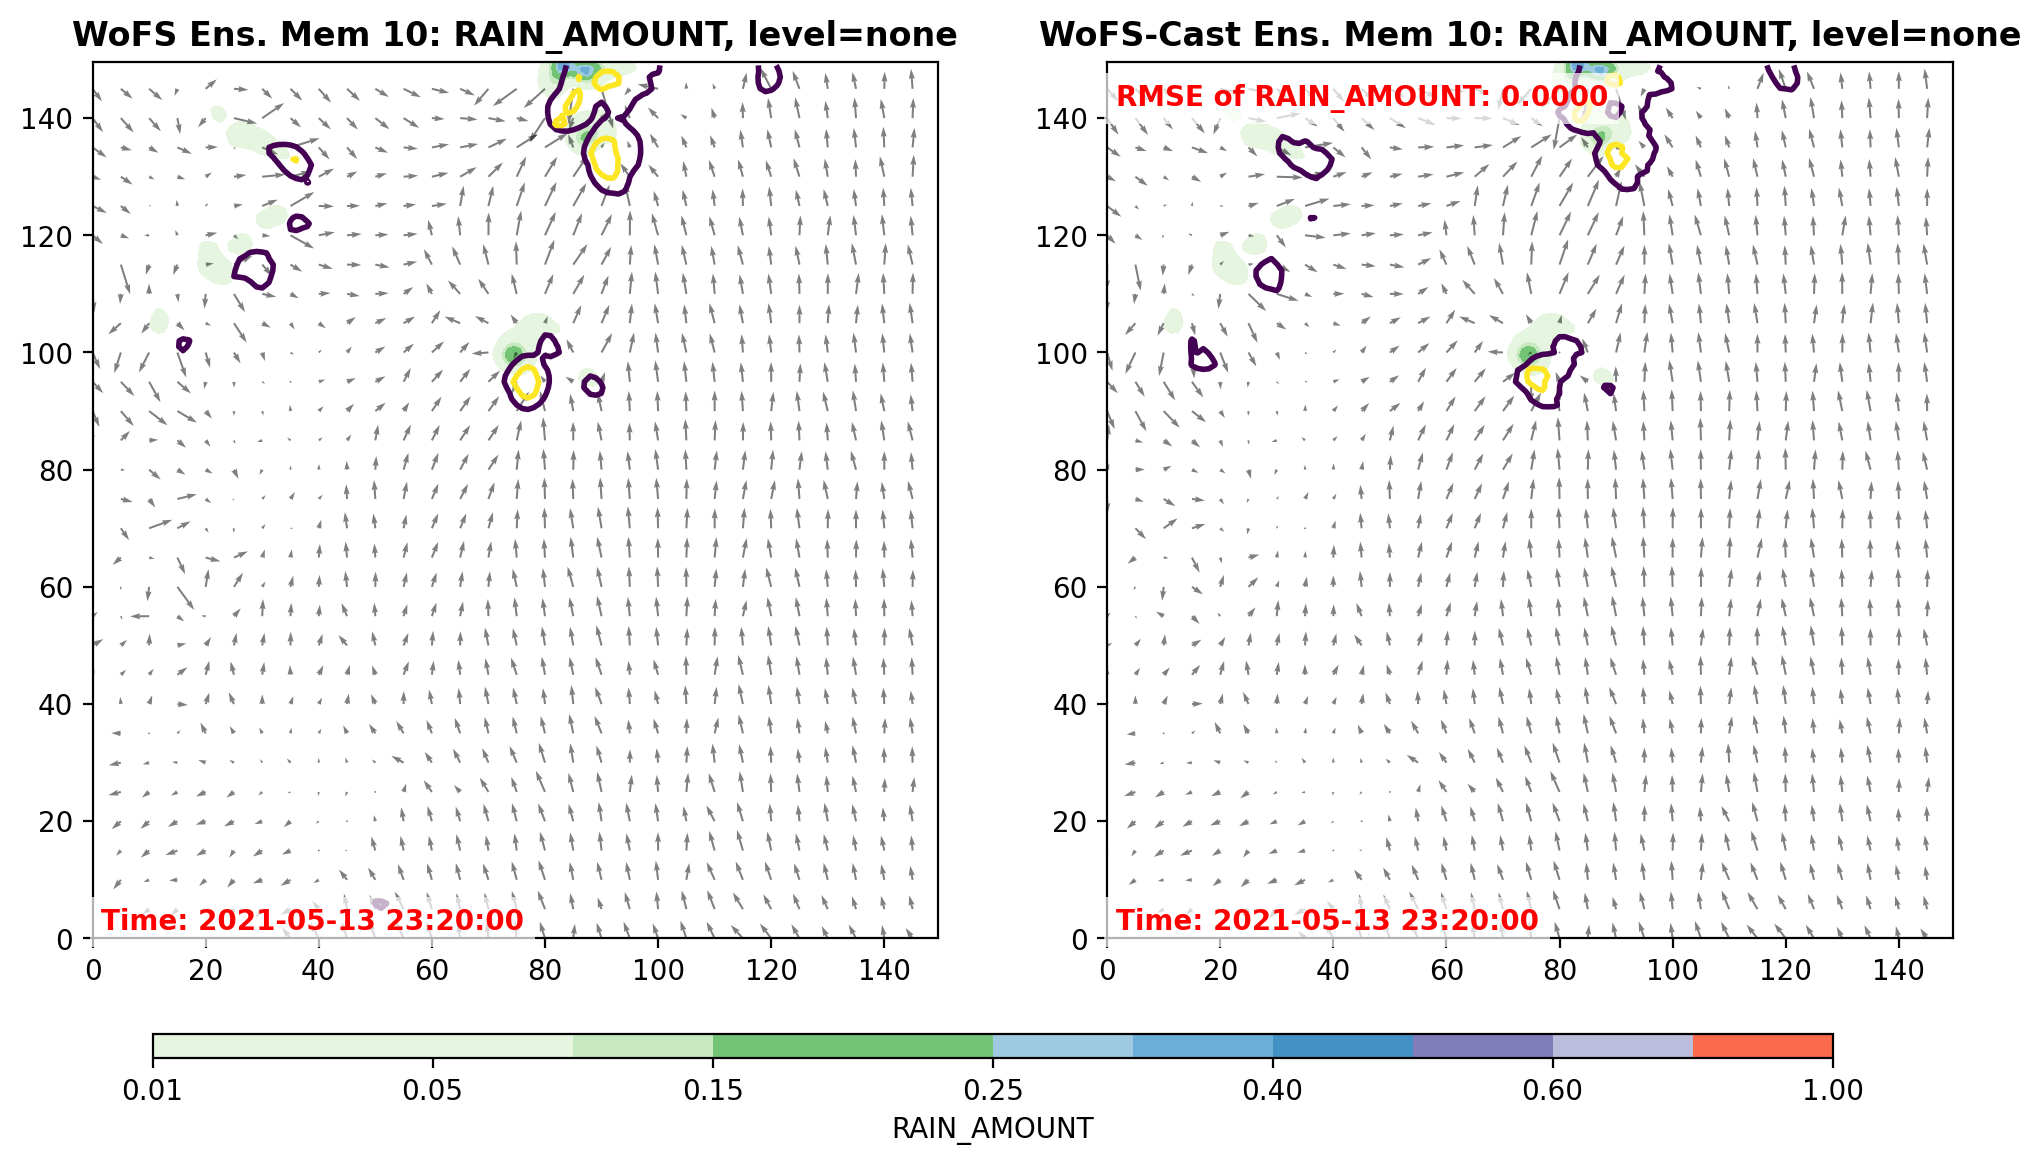

In [28]:
ens_mem=10

init_ds = ens_inputs.squeeze(dim='batch', drop=True)
init_ds = init_ds.isel(time=[-1], ensemble=ens_mem)
init_ds = init_ds.transpose('time', 'level', 'lat', 'lon')

preds = ens_predictions.squeeze(dim='batch', drop=True)
tars = ens_targets.squeeze(dim='batch', drop=True)


# Set the target as the ensemble mean
tars = tars.isel(ensemble=ens_mem)
#tars = tars.mean(dim='ensemble')

preds = preds.isel(ensemble=ens_mem)
#preds = preds.mean(dim='ensemble')

#titles = [f'WoFS Ens. Mean: {var}, level={level}', 
#          f'WoFS-Cast Ens. Mem {ens_mem:02d}: {var}, level={level}']

titles = [f'WoFS Ens. Mem {ens_mem:02d}: {var}, level={level}', 
          f'WoFS-Cast Ens. Mem {ens_mem:02d}: {var}, level={level}']


preds = preds.transpose('time', 'level', 'lat', 'lon')
tars = tars.transpose('time', 'level', 'lat', 'lon')

dts = to_datetimes(path, n_times = len(preds.time)+3)


#VARS_3D = ['U', 'V', 'W', 'T', 'GEOPOT', 'QVAPOR']
#VARS_2D = ['T2', 'COMPOSITE_REFL_10CM', 'UP_HELI_MAX', 'RAIN_AMOUNT']

var = 'RAIN_AMOUNT'
level = 'none'

domain_size = model.task_config['domain_size']

# Function to get target and prediction pair with the selected level
def get_target_and_pred_pair(preds, targets, t, level=0):

    if level == 'max':
        zs = [targets[var][t].max(dim='level').values, preds[var][t].max(dim='level').values]
    elif level == 'min': 
        zs = [targets[var][t].min(dim='level').values, preds[var][t].min(dim='level').values]
    elif level == 'none':
        zs = [targets[var][t].values, preds[var][t].values]
    else:
        zs = [targets[var][t].isel(level=level).values, preds[var][t].isel(level=level).values]
        
    if var == 'RAIN_AMOUNT':
        # Convert from mm to inches.
        zs = [z/25.4 for z in zs]
    
    if var == 'T2':
        # convert K to F 
        zs = [(9.0/5.0*(z-273.15)) + 32.0 for z in zs]
    
    return zs 


# Adjust the subplot layout to make room for the colorbar
fig, axes = plt.subplots(dpi=200, figsize=(12, 6), ncols=2, 
                         gridspec_kw={'height_ratios': [1], 'bottom': 0.15})
plt.tight_layout()

# Determine global min and max values for consistent color scaling
zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
global_min = np.percentile(zs, 1)
global_max = np.percentile(zs, 99)

if var == 'COMPOSITE_REFL_10CM':
    cmap = WoFSColors.nws_dz_cmap
    levels = WoFSLevels.dz_levels_nws
elif var == 'RAIN_AMOUNT':
    cmap = WoFSColors.rain_cmap
    levels = WoFSLevels.rain_rate_levels
elif var == 'UP_HELI_MAX':
    cmap = WoFSColors.wz_cmap_extend
    levels = WoFSLevels.uh_2to5_levels_3000m
elif var == 'T2': #or var == 'T':
    cmap = WoFSColors.temp_cmap
    levels = np.arange(40., 90., 2.5)
elif var == 'QVAPOR': 
    cmap = WoFSColors.temp_cmap
elif var == 'W': 
    cmap = WoFSColors.wz_cmap_extend
    levels = [2.5, 5, 10, 15, 20, 25, 30, 35, 40]
else:
    cmap = WoFSColors.wz_cmap_extend
    levels = 10 

# Create a colorbar axis at the bottom of the figure
# The values in `fig.add_axes` are [left, bottom, width, height], adjust as needed
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])

# Placeholder for the colorbar, to be created outside the update function
cbar = None
    
# Update function for the animation
def update(t):
    global cbar
    for ax in axes:
        ax.clear()

    if t==0:
        zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
    else:    
        zs = get_target_and_pred_pair(preds, tars, t=t, level=level)
    
    rmse = np.sqrt(np.mean((zs[0]-zs[1])**2))

    u_pred, v_pred = preds['U'][t].isel(level=0).values, preds['V'][t].isel(level=0).values
    u_tar, v_tar = tars['U'][t].isel(level=0).values, tars['V'][t].isel(level=0).values 
    u_pred = u_pred[::5, ::5]
    v_pred = v_pred[::5, ::5]
    u_tar = u_tar[::5, ::5]
    v_tar = v_tar[::5, ::5]
    wind_pred = (u_pred, v_pred)
    wind_tar = (u_tar, v_tar)
    winds = [wind_tar, wind_pred]
    x,y = np.meshgrid(np.arange(domain_size), np.arange(domain_size))
    x = x[::5, ::5]
    y = y[::5, ::5]
    
    dbz_pred = preds['COMPOSITE_REFL_10CM'][t].values
    dbz_tar = tars['COMPOSITE_REFL_10CM'][t].values
    
    dbzs = [dbz_tar, dbz_pred]
    
    color='white'
    for i, (ax, z, wind, dbz) in enumerate(zip(axes, zs, winds, dbzs)):
        if var in ['REFL_10CM', 'UP_HELI_MAX', 'COMPOSITE_REFL_10CM']:
            z = np.ma.masked_where(z < 1, z)
            color = 'black'

        im = ax.contourf(z, origin='lower', aspect='equal',
                       cmap=cmap, levels=levels)
 
        u,v = wind
        ax.quiver(x,y, u, v, alpha=0.5)
        
        ax.set_title(titles[i], fontweight='bold')
        if i == 1:
            ax.annotate(f'RMSE of {var}: {rmse:.4f}', xy=(0.01, 0.95), xycoords='axes fraction', 
                        weight='bold', color='red', 
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
        ax.annotate(f'Time: {dts[t]}', xy=(0.01, 0.01), xycoords='axes fraction', 
                        weight='bold', color='red', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))    
        
        ax.contour(dbz, levels=[35, 50], linewidths=[2.0, 2.0])
        
        # Create or update the colorbar only once as it doesn't change with frames
        if cbar is None:
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(var)

# Total number of frames
N = len(preds.time)  

# Create animation
anim = FuncAnimation(fig, update, frames=N, interval=200)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
#anim.save("wofscast.gif", writer="pillow", fps=5)